In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
def sample_prop_responsive(mean_, num_cells):
    """Sample the proportion of responsive cells.
    
    Given a population of cells, `mean_` percent of which are
    responsive, get the proportion of cells that are responsive
    in a random sample of `num_cells` cells.
    
    Calling this function once is equivalent to measuring the 
    proportion of responsive cells in one mouse.
    
    """
    responsive_cells = np.random.uniform(0, 1, size=num_cells) <= mean_
    num_responsive_cells = responsive_cells.sum()
    return num_responsive_cells / num_cells

In [63]:
params = {
    'mean prop. responsive': 0.15,  # Mean proportion of responsive cells in each mouse.
    'num. cells': 30,  # Number of cells in each mouse. Used to calculate prop. responsive.
    'num. mice': [3, 5, 10, 30, 60],
    'num. reps': 10000,  # Number of simulated experiments per condition.
}

Simulate the distribution of the mean proportion of responsive cells from 10000 experiments, averaging in two steps: 
1. average all the cells from each mouse in an experiment
2. average the average responsiveness from each mouse in an experiment.

The distribution of this "average of averages" determines what kind of statistical test you should do. Unfortunately, in your experiment, you'll only get this "average of averages" once per cell type, so it isn't possible to determine the shape of the distribution from your data. This code simulates redoing your experiment thousands of times to give us an idea of what shape that distribution might have.

In [64]:
proportions_by_num_mice = {}
for num_mice in params['num. mice']:
    proportions_by_num_mice[num_mice] = []
    for rep in range(params['num. reps']):  # Loop over experiments
        proportions_by_num_mice[num_mice].append(np.mean([sample_prop_responsive(
            params['mean prop. responsive'],
            params['num. cells']
        ) for _ in range(num_mice)]))

Text(0, 0.5, 'Density')

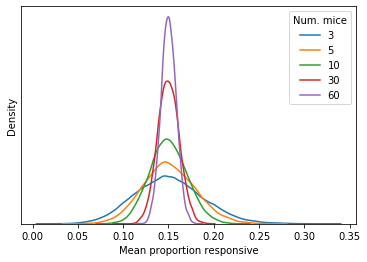

In [65]:
for num_mice in proportions_by_num_mice:
    sns.kdeplot(proportions_by_num_mice[num_mice], label=str(num_mice))
plt.legend(title='Num. mice')
plt.xlabel('Mean proportion responsive')
plt.yticks([])
plt.ylabel('Density')

The distribution of "average of averages" gets narrower and closer to Normal as your number of mice and cells/mouse increase. If you have ~50 cells/mouse, the distribution is close to Normal even if you have only a few mice.

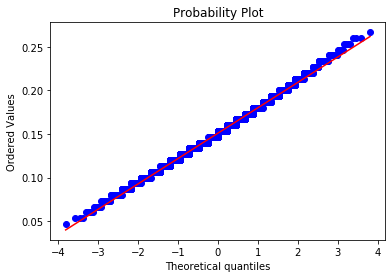

In [66]:
stats.probplot(proportions_by_num_mice[5], dist='norm', plot=plt)
plt.show()

One way to see how close the distribution of "average of averages" is to Normal is to look at a quantile-quantile (QQ) plot like the one shown above. This plots the quantiles of a Normal distribution on the x-axis against the actual quantiles of your data (y-axis). If the distribution of your data is Normal, the two should be the same and your data should lie along the diagonal. For ~50 cells/mouse and as little as 3 mice, the "average of averages" has a distribution that's close to Normal.

# False positive rate calculations

Using the wrong statistical test for your data can open you up to false positives. Since your "average of averages" is close to Normal, a t-test might be ok to use, but we can check this using simulations. 

Next I'll simulate a bunch of experiments in which the "average of averages" doesn't change from pre to post and look at how often we get p<0.05 for various tests. That gives us the false positive rate if the null hypothesis (ie, no pre post difference) is *true*. Ideally, the false positive rate should be equal to our p-value significance threshold, which is 5%.

### Setup

The classes below are for computing the false positive rate and power of various statistical tests.

In [29]:
# Classes for calculating power and false positive rate

class TestBencher:
    def __init__(self, draw_sample, stat_test, stat_test_name=None, num_reps=10000, signif_cutoff=0.05):
        self._draw_sample = draw_sample
        self._stat_test = stat_test
        
        if stat_test_name is None:
            self._stat_test_name = 'unnamed statistical test'
        else:
            self._stat_test_name = stat_test_name
            
        self.num_reps = num_reps
        self.signif_cutoff = signif_cutoff
        
        self._p_values = np.array([])
        
    def compute(self):
        self._p_values = np.array([
            self._sample_p() for _ in tqdm(range(self.num_reps), leave=False)
        ])
        return self._signif_rate_mean(), self._signif_rate_std()
        
    def _sample_p(self):
        a, b = self._draw_sample()
        p = self._stat_test(a, b)
        return p
    
    def _signif_rate_mean(self):
        assert self._p_values.size == self.num_reps
        return self._signif_rate(self._p_values)
    
    def _signif_rate_std(self):
        """Compute SD of significance rate using bootstrap."""
        signif_rates = []
        for _ in range(50):
            bs_sample = np.random.choice(self._p_values, self._p_values.size, replace=True)
            signif_rates.append(self._signif_rate(bs_sample))
        return np.std(signif_rates)
    
    def _signif_rate(self, p_values):
        p_values_ = np.asarray(p_values)
        return np.sum(p_values_ < self.signif_cutoff) / p_values_.size
    
    
class PowerCalculator(TestBencher):
    def __str__(self):
        return (
            f"Power of {self._stat_test_name} = "
            f"{100 * self._signif_rate_mean():.1f}% "
            f"+/- {100 * self._signif_rate_std():.1f}%"
        )

    
class FPRCalculator(TestBencher):
    def __str__(self):
        return (
            f"False positive rate of {self._stat_test_name} = "
            f"{100 * self._signif_rate_mean():.2f}% "
            f"+/- {100 * self._signif_rate_std():.2f}%"
        )

These are the statistical tests we'll compare

In [33]:
stat_tests = {
    'unpaired t-test': lambda a, b: stats.ttest_ind(a, b)[1],
    'paired t-test': lambda a, b: stats.ttest_rel(a, b)[1],
    'Wilcoxon signed-rank': lambda a, b: stats.wilcoxon(a, b)[1] if not np.array_equal(a, b) else 1.0,
    'Mann-Whitney U-test': lambda a, b: stats.mannwhitneyu(a, b, alternative='two-sided')[1] if not np.array_equal(a, b) else 1.0,
}

Everything from here onwards will be assuming a sample size of 6 mice and the same number of cells/mouse as before

In [34]:
NUM_MICE = 6

Method for simulating an experiment. Here we assume that the pre and post measurements of the proportion of responsive cells are totally independent. This isn't a great assumption (for reasons we'll discuss later), but it's a place to start.

In [35]:
def get_independent_sampler(pre_responsiveness, post_responsiveness):
    def sample_independent():
        """Sample pre and post proportion of responsive cells, assuming independence."""
        pre = [sample_prop_responsive(pre_responsiveness, params['num. cells']) for i in range(NUM_MICE)]
        post = [sample_prop_responsive(post_responsiveness, params['num. cells']) for i in range(NUM_MICE)]
        return np.array(pre), np.array(post)
    
    return sample_independent

Function to calculate and print false positive rates.

In [36]:
def print_fpr_benchmarks(sampler):
    """Print the false positive rate of each test given a function for sampling from the null hypothesis."""
    for test_name, test_func in stat_tests.items():
        false_pos_rate_calculator = FPRCalculator(
            sampler, test_func, test_name
        )
        false_pos_rate_calculator.compute()
        print(false_pos_rate_calculator)

### False positive rate assuming independent samples

In [37]:
print_fpr_benchmarks(get_independent_sampler(0.2, 0.2))

False positive rate of unpaired t-test = 4.71% +/- 0.20%


<ipython-input-29-aee0dabd8642>:43: RuntimeWarning: invalid value encountered in less
  return np.sum(p_values_ < self.signif_cutoff) / p_values_.size


False positive rate of paired t-test = 4.75% +/- 0.17%


/opt/miniconda3/envs/candice/lib/python3.8/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


False positive rate of Wilcoxon signed-rank = 2.43% +/- 0.16%


False positive rate of Mann-Whitney U-test = 3.42% +/- 0.18%


The false positive rates are all pretty close to 5%, so if we get p<0.05 we can safely reject the null hypothesis using any of these tests. In other words, if you apply any of these tests to your percent responsive data and get p<0.05, it's safe to say that the percent responsiveness is changing somehow.

### Independent samples assumption is wrong

The above power calculations assume that the pre and post proportion of responsive cells within each mouse are totally independent. This would be a reasonable assumption if you were sampling a different set of cells at pre and post within each mouse. Since you aren't, these false positive rates probably aren't quite right.

## Null hypothesis for paired samples

If we assume that the pre and post proportions of responsive cells aren't independent, we can model the variability in proportion of responsive cells in two parts:
- sampling variability (captured by `sample_prop_responsive`)
- variability in the amount of change in proportion of responsive cells.

We can capture the second source of variability by multiplying the proportion of responsive cells by a variable amount that represents the amount of change in responsiveness. Under the null hypothesis, the mean change in responsiveness is zero, so the multiplier we use should be 100% +/- variability. I'll estimate the variability at SD = 25% (0.25 fold) based on the error bars on the fold change in percent responsiveness graphs from your preliminary data. (From your graphs, it looks like the actual SD is usually lower than this, so this should be pretty conservative.)

Note to Emerson: The variability here is modeled using a Normal distribution because it's a sum of iid noise associated with the cells within a mouse. There are >30 cells in each mouse, so we can lean on the central limit theorem.

In [38]:
def get_paired_sampler(pre_responsiveness, responsiveness_variability, responsiveness_fold_change):
    def sample_paired():
        """Sample pre and post proportion of responsive cells, assuming paired measurements.
    
        The 'pre' proportion of responsive cells is generated as before.
        The 'post' proportion of reponsive cells is a random Normal pct change from
        the 'pre' proportion.

        """
        pre = [sample_prop_responsive(pre_responsiveness, params['num. cells']) for _ in range(NUM_MICE)]
        post = np.array(pre) * np.clip(
            1 + np.random.normal(responsiveness_fold_change, responsiveness_variability, NUM_MICE), 0, np.inf
        )
        return np.array(pre), np.array(post)
    
    return sample_paired

In [39]:
print_fpr_benchmarks(get_paired_sampler(0.2, 0.25, 0.0))

False positive rate of unpaired t-test = 0.02% +/- 0.01%


<ipython-input-29-aee0dabd8642>:43: RuntimeWarning: invalid value encountered in less
  return np.sum(p_values_ < self.signif_cutoff) / p_values_.size


False positive rate of paired t-test = 0.88% +/- 0.08%


False positive rate of Wilcoxon signed-rank = 0.69% +/- 0.08%


False positive rate of Mann-Whitney U-test = 0.18% +/- 0.04%


Under this paired samples model, the false positive rate is still under 5% for all of the tests except Wilcoxon signed-rank. The fact that the false positive rates are *under* 5% suggests that we might be losing some power, but at least we don't have to worry about flase positives. For the Wilcoxon signed-rank test, the false positive rate near 6% means that we might get some false positives if we choose this test.

## Summary of false positive rate calculations

Assuming you have ~6 mice and ~50 cells/mouse, the false positive rate for both parametric and non-parametric tests doesn't go much above 5%. This means that you can probably safely use any test you like without having to worry too much about false positives.

# Power calculations

If p<0.05, we can safely say that the percent responsiveness is changing, but what does it mean if p>0.05? The answer depends on the power of the test to detect changes in percent responsiveness. The power of a test tells us the percentage of the time that the test will give us p<0.05 if the null hypothesis is *false*. Ideally, we should aim for a power of at least 80%.

**Example**
If you get p=0.09 from a t-test with a power of 90%, we can safely accept the null hypothesis and conclude that the percent responsiveness is not changing. If, on the other hand, you get the same p-value with a power of 30%, we cannot reject the null hypothesis, but we probably shouldn't accept it either.

In [21]:
def print_power_benchmarks(sampler):
    """Print the power of each test given a function for sampling from the alt hypothesis."""
    for test_name, test_func in stat_tests.items():
        power_calculator = PowerCalculator(
            sampler, test_func, test_name
        )
        power_calculator.compute()
        print(power_calculator)

### Assuming independent (unpaired) samples

In [22]:
print_power_benchmarks(get_independent_sampler(0.2, 0.3))

Power of unpaired t-test = 22.1% +/- 0.4%


Power of paired t-test = 18.9% +/- 0.4%


<ipython-input-7-aee0dabd8642>:43: RuntimeWarning: invalid value encountered in less
  return np.sum(p_values_ < self.signif_cutoff) / p_values_.size


Power of Wilcoxon signed-rank = 15.9% +/- 0.3%


Power of Mann-Whitney U-test = 17.3% +/- 0.4%


Under the assumption of independent pre and post proportions used at the top of the false positive section, we get a power of around 60% - 70% to detect an increase from 20% to 30% responsive. This isn't too bad, but isn't anything to write home about, either.

In [23]:
print_power_benchmarks(get_independent_sampler(0.2, 0.1))

Power of unpaired t-test = 29.1% +/- 0.5%


Power of paired t-test = 25.3% +/- 0.5%


<ipython-input-7-aee0dabd8642>:43: RuntimeWarning: invalid value encountered in less
  return np.sum(p_values_ < self.signif_cutoff) / p_values_.size


Power of Wilcoxon signed-rank = 18.5% +/- 0.3%


Power of Mann-Whitney U-test = 23.8% +/- 0.5%


Under the same assumptions, we get a power of 80% - 90% to detect a decrease from 20% to 10% responsive. This is good!

### Assuming paired samples

#### Increase in percent responsive

In [24]:
print_power_benchmarks(get_paired_sampler(0.2, 0.25, 0.5))

Power of unpaired t-test = 4.0% +/- 0.2%


Power of paired t-test = 70.2% +/- 0.5%


Power of Wilcoxon signed-rank = 81.8% +/- 0.4%


Power of Mann-Whitney U-test = 4.0% +/- 0.2%


For an increase from roughly 20% responsive to ~30% responsive (0.5-fold increase), we have a power of ~95% for both paired tests. This is really good!

In [19]:
print_power_benchmarks(get_paired_sampler(0.2, 0.25, 0.25))

Power of unpaired t-test = 9.0% +/- 0.3%


Power of paired t-test = 46.2% +/- 0.5%


Power of Wilcoxon signed-rank = 53.1% +/- 0.5%


Power of Mann-Whitney U-test = 7.2% +/- 0.2%


For an increase from 20% to 25% (0.25-fold increase), we have a power of ~50% for unpaired tests. This is not so good.

#### Decrease in percent responsiveness

In [20]:
print_power_benchmarks(get_paired_sampler(0.2, 0.25, -0.5))

Power of unpaired t-test = 82.8% +/- 0.4%


Power of paired t-test = 94.9% +/- 0.2%


Power of Wilcoxon signed-rank = 96.7% +/- 0.2%


Power of Mann-Whitney U-test = 75.9% +/- 0.5%


In [21]:
print_power_benchmarks(get_paired_sampler(0.2, 0.25, -0.25))

Power of unpaired t-test = 21.0% +/- 0.4%


Power of paired t-test = 46.6% +/- 0.5%


Power of Wilcoxon signed-rank = 53.5% +/- 0.5%


Power of Mann-Whitney U-test = 18.4% +/- 0.4%


Similar results for a decrease from 20% responsive to 10% or 15% responsive.

## Summary of power calculations

If we assume that the pre and post measurements of percent responsive cells are independent, the best option is to use an unpaired t-test.

Since we know that the pre and post measurements of responsiveness are *not* independent (the cells being used to calculate percent responsiveness are the same in the pre and post conditions, so the measurements are paired), it's pretty hard to justify using an unpaired test. In the model that reflects this, we get a power of >90% for both the paired t-test and Wilcoxon signed rank test. This means it doesn't matter much which test we choose based on power.

# Conclusion

1. Under conservative assumptions, the distribution of the mean percent responsive cells is close to Normal if you have ~50 cells/mouse. This means using a t-test is probably ok.
2. The false positive rate simulations show that none of the tests are likely to produce many false positives.
    - In some circumstances, the Wilcoxon signed-rank test might produce ~6% false positives, compared with ~5% for a t-test.
3. The power simulations show that both of the paired tests have excellent power in the paired data simulations, and good power in the unpaired data simulations.

Taken together, these three points mean that there's no good reason not to use a paired t-test, and in fact the false positive rate might be slightly lower than the Wilcoxon signed-rank test. If you find the assumptions I used in my simulations reasonable, that would justify using the paired t-test.